In [21]:
import warnings
from plot_metric.functions import BinaryClassification
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn.model_selection import GridSearchCV, train_test_split
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, recall_score,precision_score, confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data= pd.read_csv('../z_norm.csv')


### split data en X et Y

In [5]:
data1= data.copy()
X= data1.drop('Loan Status', axis=1)
Y= data1['Loan Status']

In [6]:
X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 123, stratify=Y)


In [7]:
np.unique(Y_train, return_counts=True)

(array([0, 1]), array([12971, 35995]))

### ---KNN---

In [8]:
knn = KNeighborsClassifier()
params={'n_neighbors' : [2, 3, 4, 5, 6, 7, 8],
        'metric': ['minkowski','euclidean','manhattan']}

##accuracy
grid_search_acc= GridSearchCV(estimator=knn, param_grid= params, scoring='accuracy',cv=5, n_jobs=-1)
grid_search_acc= grid_search_acc.fit(X_train, Y_train)
y_predict= grid_search_acc.best_estimator_.predict(X_test)

----------
best parameters:  {'n_neighbors': 7, 'metric': 'manhattan'}
----------
[[1218 2025]
 [ 641 8358]]
----------
              precision    recall  f1-score   support

           0       0.66      0.38      0.48      3243
           1       0.80      0.93      0.86      8999

    accuracy                           0.78     12242
   macro avg       0.73      0.65      0.67     12242
weighted avg       0.77      0.78      0.76     12242

----------


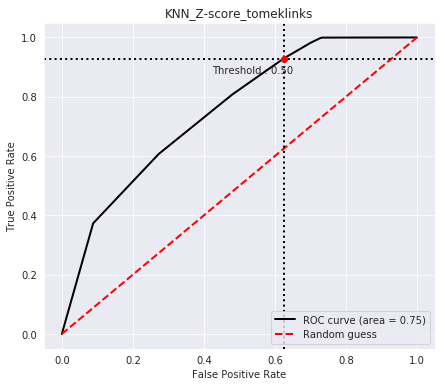

In [9]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_acc.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")


##ROC
y_predict_proba = grid_search_acc.best_estimator_.predict_proba(X_test)[:,1]

# Visualisation with plot_metric
bc = BinaryClassification(Y_test, y_predict_proba, labels=[1, 0])
# Figures
plt.figure(figsize=(7,6))
bc.plot_roc_curve()
plt.title('KNN_Z-score_tomeklinks')
plt.show()

In [10]:
## Recall
rec_avg=make_scorer(recall_score, average='macro')
grid_search_rec= GridSearchCV(estimator=knn, param_grid= params, scoring=rec_avg,cv=5, n_jobs=-1)
grid_search_rec= grid_search_rec.fit(X_train, Y_train)
y_predict= grid_search_rec.best_estimator_.predict(X_test)

In [11]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_rec.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'n_neighbors': 4, 'metric': 'minkowski'}
----------
[[1650 1593]
 [1775 7224]]
----------
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      3243
           1       0.82      0.80      0.81      8999

    accuracy                           0.72     12242
   macro avg       0.65      0.66      0.65     12242
weighted avg       0.73      0.72      0.73     12242

----------


In [12]:
## precision
prec_avg=make_scorer(precision_score, average='macro')
grid_search_prec_avg= GridSearchCV(estimator=knn, param_grid= params, scoring=prec_avg,cv=5, n_jobs=-1)
grid_search_prec_avg= grid_search_prec_avg.fit(X_train, Y_train)
y_predict= grid_search_prec_avg.best_estimator_.predict(X_test)

In [13]:
## evaluating the model
print("----------")
print('best parameters: ', grid_search_prec_avg.best_params_)
print("----------")
print(confusion_matrix(Y_test,y_predict))
print("----------")
print(classification_report(Y_test, y_predict))
print("----------")

----------
best parameters:  {'n_neighbors': 7, 'metric': 'manhattan'}
----------
[[1218 2025]
 [ 641 8358]]
----------
              precision    recall  f1-score   support

           0       0.66      0.38      0.48      3243
           1       0.80      0.93      0.86      8999

    accuracy                           0.78     12242
   macro avg       0.73      0.65      0.67     12242
weighted avg       0.77      0.78      0.76     12242

----------


In [23]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, titre):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.set_ylim([0.6,0.83])
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title(titre, fontsize=18, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel(titre+'[CV Avg Score]', fontsize=14)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

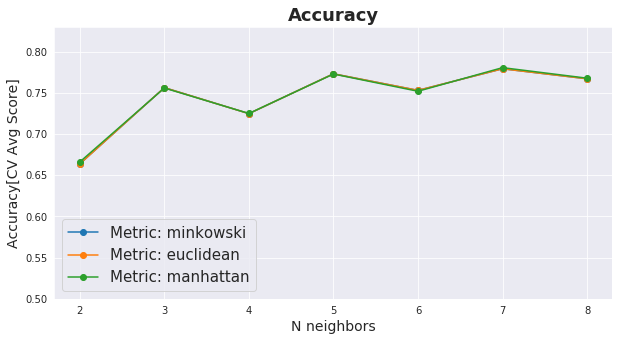

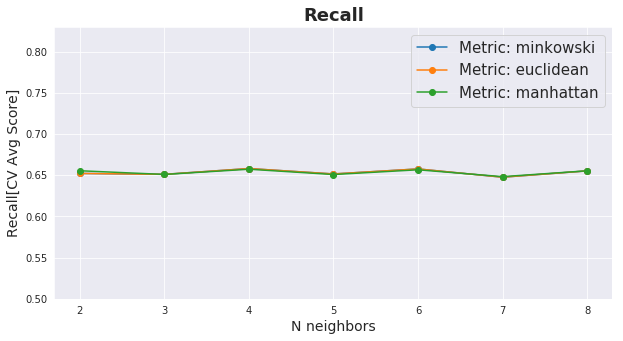

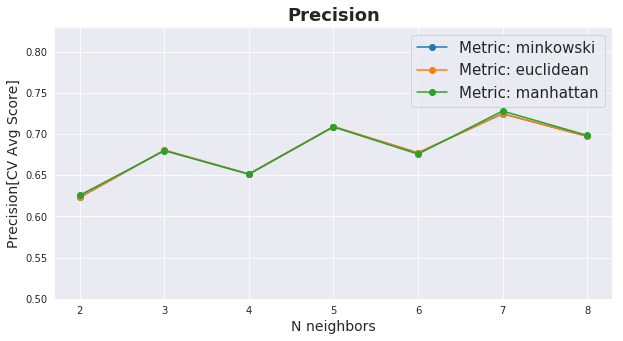

In [22]:
# Calling Method 
plot_grid_search(grid_search_acc.cv_results_, params['n_neighbors'], params['metric'], 'N neighbors', 'Metric', 'Accuracy')
plot_grid_search(grid_search_rec.cv_results_, params['n_neighbors'], params['metric'], 'N neighbors', 'Metric', 'Recall')
plot_grid_search(grid_search_prec_avg.cv_results_, params['n_neighbors'], params['metric'], 'N neighbors', 'Metric', 'Precision')


In [16]:
def return_index_list(param1, param2):
    list=[]
    for p1 in param1:
        for p2 in param2:
            list.append('['+str(p1)+', '+str(p2)+']')
    return list
index= return_index_list(params['metric'], params['n_neighbors'])

In [17]:
df= pd.DataFrame({  'Accuracy': grid_search_acc.cv_results_['mean_test_score'],
                    'Precision(Avg)': grid_search_prec_avg.cv_results_['mean_test_score'],
                    'Recall(Avg)': grid_search_rec.cv_results_['mean_test_score'],},
                 index=index)

path= "../../tables_tomeklinks.xlsx"
writer = pd.ExcelWriter(path)
from openpyxl import load_workbook
writer.book= load_workbook(path)
df.to_excel(writer, 'knn_z')
writer.save()
writer.close()

In [18]:
df

,Accuracy,Precision(Avg),Recall(Avg)
"[minkowski, 2]",0.663848,0.623138,0.652216
"[minkowski, 3]",0.756382,0.680483,0.651121
"[minkowski, 4]",0.724809,0.651524,0.658149
"[minkowski, 5]",0.773190,0.709099,0.651581
"[minkowski, 6]",0.753074,0.677216,0.657673
"[minkowski, 7]",0.779275,0.724730,0.647633
"[minkowski, 8]",0.767124,0.697278,0.655297
"[euclidean, 2]",0.663848,0.623138,0.652216
"[euclidean, 3]",0.756382,0.680483,0.651121
"[euclidean, 4]",0.724809,0.651524,0.658149
